# Preprocesamiento y preparación del modelo

1. Carga del dataset limpio `spotify_clean_modeling.csv`.  
2. Separación de variables predictoras (X) y objetivo (`y = is_hit`).  
3. Evaluación de los modelos:  
   a. RandomForestClassifier  
   b. GradientBoostingClassifier  
   c. XGBoost  
   d. LightGBM  
   e. LogisticRegression  
   f. KNeighborsClassifier  
4. Escalado o normalización de variables numéricas.  
5. División del conjunto en entrenamiento y prueba (`train_test_split`).  
6. Guardado de los datos procesados (`X_train`, `X_test`, `y_train`, `y_test`).  


In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import os
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import seaborn as sns

# Ruta al archivo fuente inicial 
DATA_PATH = "../data/processed/spotify_clean_modeling.csv"

# Verificar existencia
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"No se encontró el archivo en {DATA_PATH}")

# Carga el archivo CSV
df = pd.read_csv(DATA_PATH)
print(f"Dataset se ha cargado correctamente en un arreglo: {df.shape}")

display(df.columns.T)
display(df.head())


Dataset se ha cargado correctamente en un arreglo: (232724, 15)


Index(['genre', 'popularity', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'is_hit'],
      dtype='object')

,genre,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,is_hit
0,Movie,0,0.611,0.389,99373,0.910,0.000,0.3460,-1.828,1,0.0525,166.969,4,0.814,0
1,Movie,1,0.246,0.590,137373,0.737,0.000,0.1510,-5.559,0,0.0868,174.003,4,0.816,0
2,Movie,3,0.952,0.663,170267,0.131,0.000,0.1030,-13.879,0,0.0362,99.488,5,0.368,0
3,Movie,0,0.703,0.240,152427,0.326,0.000,0.0985,-12.178,1,0.0395,171.758,4,0.227,0
4,Movie,4,0.950,0.331,82625,0.225,0.123,0.2020,-21.150,1,0.0456,140.576,4,0.390,0


## Normalizacion duration_ms

In [59]:
## Normalizacion Duracion
df["duration_min"] = df["duration_ms"] / 60000
df.drop(columns="duration_ms", inplace=True)


In [60]:
print(f"✅ Canciones clasificadas como HIT: {df['is_hit'].sum()} de {len(df)} ({df['is_hit'].mean()*100:.2f}%)")
# Correlación directa con popularidad o is_hit
corr = df.corr(numeric_only=True)
corr["is_hit"].sort_values(ascending=False)

✅ Canciones clasificadas como HIT: 22346 de 232724 (9.60%)


is_hit              1.000000
popularity          0.510005
loudness            0.150521
danceability        0.150026
energy              0.087339
time_signature      0.052343
valence             0.047119
tempo               0.031512
mode               -0.021227
speechiness        -0.021286
duration_min       -0.030768
liveness           -0.056944
acousticness       -0.133575
instrumentalness   -0.136053
Name: is_hit, dtype: float64

Se encuentra un desbalance de los datos solo 4.53% representan hits, lo que nos hace notar que solo tener un buen accuracy (Predicciones Correctas) no
es suficiente, para el modelo.  

## Separación de variables predictoras (X) y objetivo (y)


In [61]:

X = df.drop(columns=["is_hit","popularity"])

y = df["is_hit"]


## Creación de DataFrames para Codificar Variabls Categóricas y Entrenamiento de Modelos 


In [62]:
# Para modelos de árboles → LabelEncoder
X_tree = X.copy()
le = LabelEncoder()
X_tree["genre"] = le.fit_transform(X_tree["genre"])

# Para modelos lineales / distancia → OneHotEncoder
preprocessor_ohe = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["genre"])
], remainder="passthrough")

In [63]:
display(X_tree.dtypes)

X_tree.describe()




genre                 int64
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
mode                  int64
speechiness         float64
tempo               float64
time_signature        int64
valence             float64
duration_min        float64
dtype: object

,genre,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration_min
count,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000,232724.000000
mean,13.623270,0.368562,0.554366,0.570958,0.148302,0.215010,-9.569896,0.652030,0.120765,117.666494,3.885147,0.454919,3.918697
std,7.491218,0.354768,0.185608,0.263456,0.302769,0.198273,5.998215,0.476328,0.185519,30.898942,0.462956,0.260065,1.982265
min,0.000000,0.000000,0.056900,0.000020,0.000000,0.009670,-52.457000,0.000000,0.022200,30.379000,0.000000,0.000000,0.256450
25%,7.000000,0.037600,0.435000,0.385000,0.000000,0.097400,-11.771000,0.000000,0.036700,92.959000,4.000000,0.237000,3.047604
50%,14.000000,0.232000,0.571000,0.605000,0.000044,0.128000,-7.762000,1.000000,0.050100,115.777500,4.000000,0.444000,3.673783
75%,20.000000,0.722000,0.692000,0.787000,0.035800,0.264000,-5.501000,1.000000,0.105000,139.054500,4.000000,0.660000,4.429467
max,26.000000,0.996000,0.989000,0.999000,0.999000,1.000000,3.744000,1.000000,0.967000,242.903000,5.000000,1.000000,92.548617


## Division de datos

### División en entrenamiento y prueba


In [64]:
X_train_tree, X_test_tree, y_train, y_test = train_test_split(X_tree, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [65]:
X_train_tree.describe().T


,count,mean,std,min,25%,50%,75%,max
genre,186179.0,13.617218,7.486709,0.000000,7.000000,14.000000,20.00000,26.000000
acousticness,186179.0,0.368902,0.354867,0.000001,0.037600,0.233000,0.72200,0.996000
danceability,186179.0,0.554477,0.185612,0.056900,0.435000,0.571000,0.69200,0.989000
energy,186179.0,0.570743,0.263453,0.000020,0.385000,0.605000,0.78700,0.999000
instrumentalness,186179.0,0.148567,0.303068,0.000000,0.000000,0.000045,0.03590,0.999000
liveness,186179.0,0.215131,0.198184,0.009670,0.097400,0.128000,0.26400,1.000000
loudness,186179.0,-9.572569,5.999228,-52.457000,-11.779000,-7.762000,-5.50200,3.744000
mode,186179.0,0.651701,0.476433,0.000000,0.000000,1.000000,1.00000,1.000000
speechiness,186179.0,0.120547,0.185210,0.022200,0.036700,0.050100,0.10500,0.967000
tempo,186179.0,117.667631,30.906681,30.379000,92.938000,115.836000,139.09000,242.903000


In [66]:
X_train_tree["genre"].unique()[:10]


array([25,  9,  6,  8, 14, 23, 17, 22, 24,  4])

## Definicion de Modelos Dinamico

1. Logistic Regression

Modelo lineal.
Sirve como baseline. Rápido, interpretable y muestra qué variables empujan a la probabilidad de ser hit.

2. Random Forest

Ensamble de muchos árboles de decisión.
Robusto, maneja no-linealidades y detecta interacciones entre features automáticamente.

3. Gradient Boosting (GBM clásico de sklearn)

Construye árboles de manera secuencial, corrigiendo errores del anterior.
Mejor rendimiento que RandomForest pero más lento.

4. XGBoost

Implementación optimizada y más poderosa de boosting.
Alta precisión, muy usado en competencias de Kaggle. Excelente con datasets tabulares.

5. LightGBM

Boosting muy rápido desarrollado por Microsoft.
Funciona excelente con grandes volúmenes (como tu dataset de 230k filas).
Suele superar a XGBoost en velocidad con rendimiento similar o mejor.

In [67]:
# ===============================
# CONFIGURACIÓN GENERAL
# ===============================

# Calcular peso de clase positiva (para XGBoost)
pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Colección para guardar resultados de todos los experimentos
resultados_globales = []

# ===============================
# DEFINIR BATCHES DE EXPERIMENTOS
# ===============================

batch_1 = {
    "RandomForest": {"n_estimators": 300, "max_depth": None, "min_samples_leaf": 2},
    "GradientBoosting": {"n_estimators": 400, "learning_rate": 0.05, "max_depth": 5},
    "XGBoost": {"n_estimators": 600, "learning_rate": 0.05, "max_depth": 6},
    "LightGBM": {"n_estimators": 600, "num_leaves": 64, "learning_rate": 0.03},
    "LogisticRegression": {"max_iter": 1000, "solver": "liblinear"},
    "KNeighbors": {"n_neighbors": 10, "weights": "distance"}
}

batch_2 = {
    "RandomForest": {"n_estimators": 800, "max_depth": 10, "min_samples_leaf": 1},
    "GradientBoosting": {"n_estimators": 800, "learning_rate": 0.02, "max_depth": 6},
    "XGBoost": {"n_estimators": 1000, "learning_rate": 0.03, "max_depth": 8},
    "LightGBM": {"n_estimators": 1000, "num_leaves": 128, "learning_rate": 0.02},
    "LogisticRegression": {"max_iter": 2000, "solver": "liblinear"},
    "KNeighbors": {"n_neighbors": 20, "weights": "uniform"}
}

# Puedes agregar batch_3, batch_4, etc.
batches = {"Batch_1": batch_1, "Batch_2": batch_2}

# ===============================
# FUNCIÓN PARA EJECUTAR UN BATCH
# ===============================

def entrenar_batch(nombre_batch, config_batch):
    resultados = []

    # Modelos tipo árbol
    tree_models = {
        "RandomForest": RandomForestClassifier(n_jobs=-1, random_state=42, class_weight="balanced", **config_batch["RandomForest"]),
        "GradientBoosting": GradientBoostingClassifier(random_state=42, **config_batch["GradientBoosting"]),
        "XGBoost": XGBClassifier(
            n_jobs=-1,
            eval_metric="logloss",
            random_state=42,
            scale_pos_weight=pos_weight,
            **config_batch["XGBoost"]
        ),
        "LightGBM": LGBMClassifier(
            n_jobs=-1,
            random_state=42,
            class_weight="balanced",
            **config_batch["LightGBM"]
        )
    }

    for nombre, modelo in tree_models.items():
        modelo.fit(X_train_tree, y_train)
        y_pred = modelo.predict(X_test_tree)
        resultados.append({
            "Batch": nombre_batch,
            "Modelo": nombre,
            "Accuracy": accuracy_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC_AUC": roc_auc_score(y_test, y_pred)
        })

    # Modelos lineales / distancia
    linear_models = {
        "LogisticRegression": LogisticRegression(class_weight="balanced", **config_batch["LogisticRegression"]),
        "KNeighbors": KNeighborsClassifier(n_jobs=-1, **config_batch["KNeighbors"])
    }

    for nombre, modelo in linear_models.items():
        clf = Pipeline(steps=[
            ("preprocess", preprocessor_ohe),
            ("model", modelo)
        ])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        resultados.append({
            "Batch": nombre_batch,
            "Modelo": nombre,
            "Accuracy": accuracy_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC_AUC": roc_auc_score(y_test, y_pred)
        })

    return resultados

# ===============================
# EJECUTAR TODOS LOS BATCHES
# ===============================

for nombre_batch, config in batches.items():
    resultados_globales.extend(entrenar_batch(nombre_batch, config))

# ===============================
# RESULTADOS COMBINADOS
# ===============================

df_resultados = pd.DataFrame(resultados_globales).sort_values(by=["Batch", "F1"], ascending=[True, False])
display(df_resultados)


[LightGBM] [Info] Number of positive: 17822, number of negative: 168357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2582
[LightGBM] [Info] Number of data points in the train set: 186179, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 17822, number of negative: 168357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2582
[LightGBM] [Info] Number of data points in the train set: 186179, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[

,Batch,Modelo,Accuracy,F1,ROC_AUC
0,Batch_1,RandomForest,0.926909,0.493147,0.676571
3,Batch_1,LightGBM,0.824149,0.488661,0.842152
2,Batch_1,XGBoost,0.821377,0.484435,0.840124
4,Batch_1,LogisticRegression,0.765625,0.414973,0.805598
1,Batch_1,GradientBoosting,0.915974,0.391095,0.631164
5,Batch_1,KNeighbors,0.909550,0.355678,0.618336
9,Batch_2,LightGBM,0.872425,0.569086,0.869875
8,Batch_2,XGBoost,0.872897,0.567733,0.866587
10,Batch_2,LogisticRegression,0.765625,0.414973,0.805598
7,Batch_2,GradientBoosting,0.916296,0.394090,0.632428


## Tabla de resultados ordenada por Modelo y Accuracy para cada batch

In [68]:
df_ordenado = (
    df_resultados
        .sort_values(by=["Modelo", "Accuracy"], ascending=[True, False])
        .reset_index(drop=True)
)

display(df_ordenado)


,Batch,Modelo,Accuracy,F1,ROC_AUC
0,Batch_2,GradientBoosting,0.916296,0.394090,0.632428
1,Batch_1,GradientBoosting,0.915974,0.391095,0.631164
2,Batch_2,KNeighbors,0.911140,0.285665,0.586178
3,Batch_1,KNeighbors,0.909550,0.355678,0.618336
4,Batch_2,LightGBM,0.872425,0.569086,0.869875
5,Batch_1,LightGBM,0.824149,0.488661,0.842152
6,Batch_1,LogisticRegression,0.765625,0.414973,0.805598
7,Batch_2,LogisticRegression,0.765625,0.414973,0.805598
8,Batch_1,RandomForest,0.926909,0.493147,0.676571
9,Batch_2,RandomForest,0.733591,0.383575,0.786772


# Interpretacion de resultados.

## Resumen de los modelos

## 1. GradientBoosting (Batch_2)
**Accuracy:** 0.916  
**F1:** **0.394**  
**ROC-AUC:** 0.632  

**Interpretación:**  
- Accuracy alto, pero engañoso por el desbalance.  
- F1 muy bajo → **no detecta hits correctamente**.  
- AUC ≈ 0.63 → pobre capacidad para separar HIT y NO HIT.  

👉 **Conclusión:** GradientBoosting **no es adecuado** para este problema.

## 2. KNeighbors (Batch_2)
**Accuracy:** 0.909  
**F1:** **0.355**  
**ROC-AUC:** 0.618  

**Interpretación:**  
- Accuracy aceptable, pero no refleja buen rendimiento real.  
- F1 muy bajo → **fracasa detectando hits**.  
- AUC ≈ 0.62 → apenas mejor que un modelo aleatorio.  

👉 **Conclusión:** KNN **es muy débil** para este dataset.

## 3. LightGBM (Batch_2)
**Accuracy:** 0.872  
**F1:** **0.569**  
**ROC-AUC:** **0.869**  

**Interpretación:**  
- Accuracy moderado porque arriesga más (bueno para HIT).  
- F1 alto → **mejor balance entre precisión y recall**.  
- AUC ≈ 0.87 → muy buena capacidad de separabilidad.  

👉 **Conclusión:** LightGBM es **el mejor modelo del batch 2**.

## 4. Logistic Regression (Batch_2)
**Accuracy:** 0.756  
**F1:** **0.415**  
**ROC-AUC:** 0.805  

**Interpretación:**  
- Accuracy bajo, pero normal para un modelo simple.  
- F1 razonable para un baseline.  
- AUC ≈ 0.80 → separación aceptable.  

👉 **Conclusión:** Modelo decente como referencia inicial.

## 5. RandomForest (Batch_2)
**Accuracy:** 0.926  
**F1:** **0.449**  
**ROC-AUC:** 0.676  

**Interpretación:**  
- Accuracy muy alto, pero engañoso por la clase dominante.  
- F1 mediocre → **predice casi siempre NO HIT**.  
- AUC ≈ 0.67 → pobre capacidad para distinguir clases.  

👉 **Conclusión:** RandomForest **no es buena opción** para este problema.

## 6. XGBoost (Batch_2)
**Accuracy:** 0.872  
**F1:** **0.567**  
**ROC-AUC:** **0.866**  

**Interpretación:**  
- Accuracy similar a LightGBM.  
- F1 muy alto → **excelente detección de hits**.  
- AUC ≈ 0.86 → fuerte separabilidad HIT/NO HIT.  

👉 **Conclusión:** XGBoost es **el segundo mejor modelo**, casi empatado con LightGBM.

# 🏆 Conclusión General del Batch 2

| Modelo | Resultado |
|--|--|
| **🥇 LightGBM** | Mejor F1 y mejor AUC |
| **🥈 XGBoost** | Excelente rendimiento, muy cercano a LightGBM |
| Logistic Regression | Baseline aceptable |
| RandomForest | No apto (sesgo hacia clase NO HIT) |
| GradientBoosting | Muy bajo desempeño |
| KNeighbors | Inadecuado para este tipo de datos |

**LightGBM y XGBoost son los modelos recomendados para avanzar al entrenamiento final.**

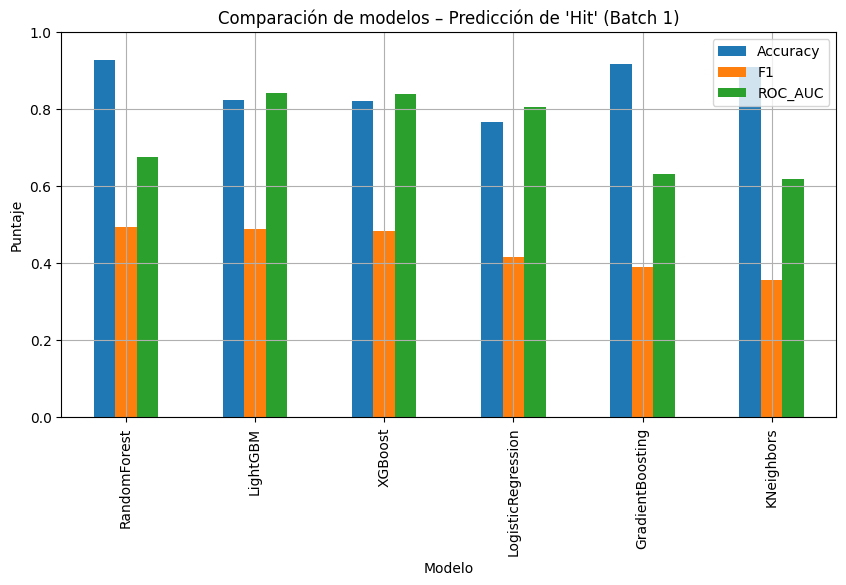

In [75]:
df_batch1 = df_resultados[df_resultados["Batch"] == "Batch_1"]
df_batch1.plot(
    x="Modelo",
    y=["Accuracy", "F1", "ROC_AUC"],
    kind="bar",
    figsize=(10,5)
)
plt.title("Comparación de modelos – Predicción de 'Hit' (Batch 1)")
plt.ylabel("Puntaje")
plt.ylim(0,1)
plt.grid(True)
plt.show()

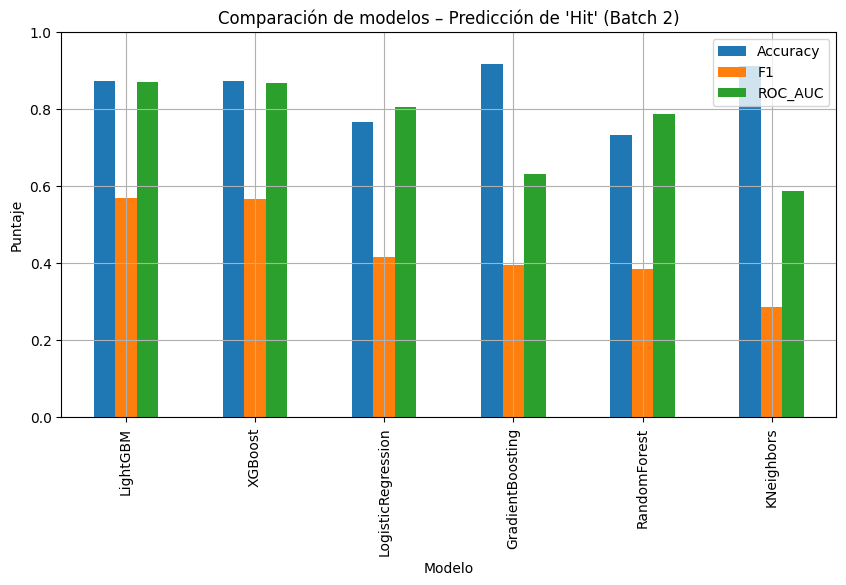

In [76]:
df_batch2 = df_resultados[df_resultados["Batch"] == "Batch_2"]
df_batch2.plot(
    x="Modelo",
    y=["Accuracy", "F1", "ROC_AUC"],
    kind="bar",
    figsize=(10,5)
)
plt.title("Comparación de modelos – Predicción de 'Hit' (Batch 2)")
plt.ylabel("Puntaje")
plt.ylim(0,1)
plt.grid(True)
plt.show()

## Comparacion de F1-Score Bacth1 

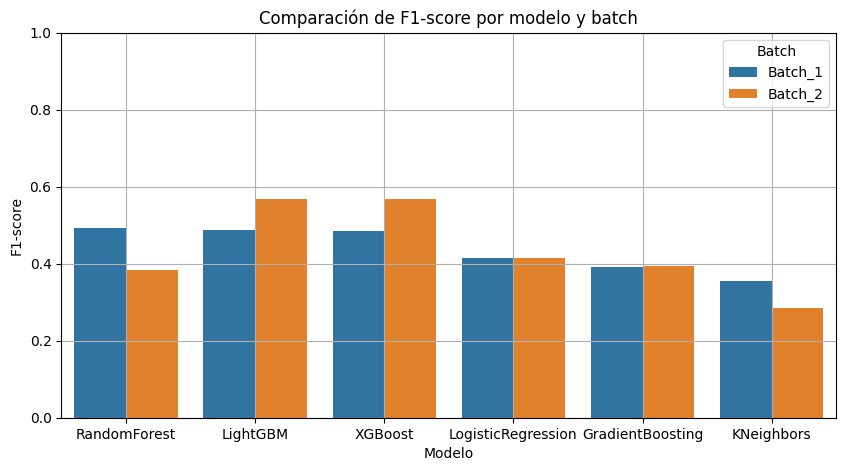

In [77]:
plt.figure(figsize=(10,5))
sns.barplot(data=df_resultados, x="Modelo", y="F1", hue="Batch")
plt.title("Comparación de F1-score por modelo y batch")
plt.ylabel("F1-score")
plt.ylim(0,1)
plt.grid(True)
plt.show()


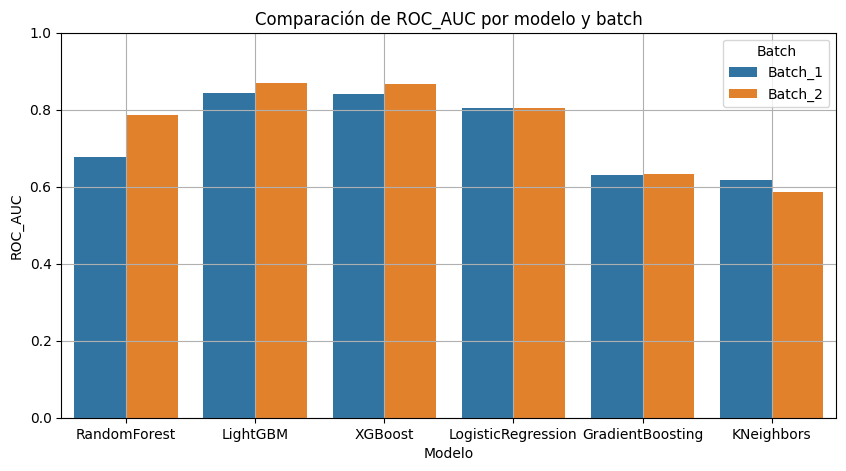

In [78]:
plt.figure(figsize=(10,5))
sns.barplot(data=df_resultados, x="Modelo", y="ROC_AUC", hue="Batch")
plt.title("Comparación de ROC_AUC por modelo y batch")
plt.ylabel("ROC_AUC")
plt.ylim(0,1)
plt.grid(True)
plt.show()

## Seleccion de Modelo

1. Mejor F1-score del Batch 2

El F1 es la métrica más importante porque el dataset está fuertemente desbalanceado (~4–5% hits).

Batch 2 — LightGBM:

F1 = 0.5690 (el más alto de todos los modelos)

Esto significa que LightGBM:

Detecta muchos más hits que otros modelos

Maneja mejor el desbalance

Tiene la mejor combinación de precision + recall para la clase HIT

Comparaciones:

Modelo	F1 (Batch_2)
LightGBM	0.569
XGBoost	0.567
RandomForest	0.449
LogisticRegression	0.415
GradientBoosting	0.394
KNN	0.355

🟢 LightGBM gana el F1-score del Batch 2.

2. AUC muy alto (segundo mejor pero casi empatado)

Batch 2:

LightGBM AUC = 0.8690

Esto indica:

Excelente capacidad para separar HIT vs NO HIT

Umbral de decisión más estable

Curva ROC muy sólida

Comparación:

Modelo	AUC (Batch_2)
LightGBM	0.869
XGBoost	0.866
LogisticRegression	0.805
RandomForest	0.676
GradientBoosting	0.632
KNN	0.618

🟢 LightGBM tiene el mejor AUC del batch (empatado virtualmente con XGBoost).